In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re
import seaborn as sns

#from src.utils.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C"}

In [3]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """

    folder = f'C:/Users/aejew/Downloads/ESS8_GB_results/{analysis_dir}'
    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}

    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


In [4]:
GB_res= load_analyses("ESS8_GB_results")
categories= ['SD1','SD2','ST1','ST2','HD1','HD2','AC1','AC2','PO1','PO2','TR1','TR2','CO1','CO2','SC1','SC2','BE1','BE2','UN1','UN2','UN3']
dat = pd.read_csv("RealData\ESS8_data.csv")
dat[categories]

,SD1,SD2,ST1,ST2,HD1,HD2,AC1,AC2,PO1,PO2,...,TR2,CO1,CO2,SC1,SC2,BE1,BE2,UN1,UN2,UN3
0,2,3,3,3,4,3,2,2,6,1,...,6,5,6,2,6,1,1,1,1,1
1,3,2,3,5,3,5,3,3,6,2,...,5,5,5,5,4,3,2,2,3,2
2,3,2,6,6,2,3,4,6,5,3,...,2,5,3,1,1,3,1,2,2,2
3,2,2,3,3,2,2,2,3,3,2,...,2,3,4,2,2,3,2,2,2,3
4,3,1,3,5,1,1,4,3,4,3,...,4,5,2,3,4,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41288,1,1,1,1,1,1,2,1,2,2,...,1,5,2,1,1,1,1,3,4,2
41289,1,1,3,4,3,2,2,1,4,2,...,1,2,1,2,1,1,1,2,2,1
41290,2,1,2,4,4,5,1,2,6,1,...,2,1,1,1,2,2,2,1,2,1
41291,2,1,1,2,1,1,2,1,3,1,...,4,5,3,2,1,1,3,2,2,2


In [5]:
old_order = ['SD1','PO1','UN1','AC1','SC1','ST1','CO1','UN2','TR1','HD1','SD2','BE1','AC2','SC2','ST2','CO2','PO2','BE2','UN3','TR2','HD2']
data = dat[old_order]

In [6]:
new_order = [data.columns.get_loc(c) for c in categories if c in data]
len(new_order)

21

In [7]:
def loss_archetype_plot(K_list, results_path: str = 'synthetic_results/1000_complex_results.json',results_path2: str = None):
    """
    A plot over the final loss obtained as a function of the number of archetypes.
    Parameters:
        - results_path (str): Path to a .json results file created by running ResultMaker.get_results()
    """

    with open(f'{results_path}', 'r') as f:
        result = json.load(f)
        df_res = pd.DataFrame(result)


    if results_path2:
        with open(f'{results_path2}', 'r') as f:
            result2 = json.load(f)
            df_res2 = pd.DataFrame(result2)

        df_res2.method = df_res2.method.replace({'CAA': 'TSAA'})    
        df_res = pd.concat([df_res,df_res2])

    df_res.method = df_res.method.replace({'OAA': 'OAA', 'RBOAA': 'RBOAA', 'CAA': 'AA','TSAA': 'TSAA'})  

    methods = df_res['method'].unique()

    methods_colors = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSAA" : "#073B4C"}
    #methods_colors = dict(zip(methods.tolist(), ["#EF476F", "#FFD166", "#06D6A0", "#073B4C"]))
    fig, ax = plt.subplots(figsize = (15,5), layout='constrained')


    def add_curve(analysis_archetypes, losses, is_min: bool, method: str):
        if is_min:
            plt.plot(analysis_archetypes, losses,"-o",c=methods_colors[method],label=f'{method}')
        else:
            # plt.scatter(analysis_archetypes, losses)
            plt.plot(analysis_archetypes, losses, alpha=0.3, c=methods_colors[method])

    ax.set_xlabel('Number of archetypes', fontsize=30)
    
    ax.set_ylabel('Cross entropy loss', fontsize=30)
    ax2 = ax.twinx()
    ax2.set_ylabel('SSE',fontsize=30)
    ax.set_ylim(0,60000)

    # TODO: Automatic set of ax2 ylim to avoid the two plots starting the same place something likemin = min(min_loss_AA, min_loss_TSOAA)*0.9 and max  = max(max_loss_AA, max_loss_TSOAA)*1.1
    #ax2.set_ylim((np.min(df_res[df_res.method=='AA'].loss[-1])-1000,np.max(df_res[df_res.method=='TSAA'].loss[0])+1000))
    #ax.set_ylim((np.min(df_res[df_res.method=='RBOAA'].loss[-1])-1000,np.max(df_res[df_res.method=='OAA'].loss[0])+1000))
    
    for method in methods:
        df_losses = df_res.loc[df_res['method'] == method][['n_archetypes', 'loss']]
        analysis_archetypes = K_list #df_losses['n_archetypes'].unique().tolist()

        all_losses = [df_losses.loc[df_losses['n_archetypes'] == e]['loss'].values for e in analysis_archetypes]
        analysis_archetypes = list(map(str, analysis_archetypes))
        losses = np.array([[e[-1] for e in loss] for loss in all_losses]) # n_archetypes x n_repeats array with losses at final iter
        
        tmp = losses[losses == np.min(losses, axis=1)[:, None]]
        _, idx = np.unique(losses[losses == np.min(losses, axis=1)[:, None]], return_index=True)
        min_losses = tmp[np.sort(idx)]
        print(str(method)+str(np.argmin(losses,axis=1)))

        
        if method in ['AA','TSAA']:
            
            ax2.plot(analysis_archetypes, min_losses,"-o",c=methods_colors[method],label=f'{method}')
            # = add_curve(analysis_archetypes, min_losses, is_min=True, method=method)

            for rep in range(losses.shape[1]):
                ax2.plot(analysis_archetypes, losses[:, rep], alpha=0.3, c=methods_colors[method])
        
        else:
            ax.plot(analysis_archetypes, min_losses,"-o",c=methods_colors[method],label=f'{method}')
            #ax.add_curve(analysis_archetypes, min_losses, is_min=True, method=method)

            for rep in range(losses.shape[1]):
                ax.plot(analysis_archetypes, losses[:, rep], alpha=0.3, c=methods_colors[method])
    

    # Not sure what diff between minor and major is
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)

    ax2.tick_params(axis='both', which='major', labelsize=25,colors = "#073B4C")
    ax2.tick_params(axis='both', which='minor', labelsize=25)

    ax.set_ylim(0,60000)

    ax2.spines['right'].set_color(methods_colors["AA"])
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0,fontsize=30)

RBOAA[8 2 2 9 4 6 8 7 7 2 9 6 3]
OAA[3 5 8 7 5 8 5 3 6 4 6 3 2]
AA[0 8 4 0 2 3 8 6 0 8 3 8 2]
TSAA[9 8 4 0 5 5 4 2 1 3 6 7 6]


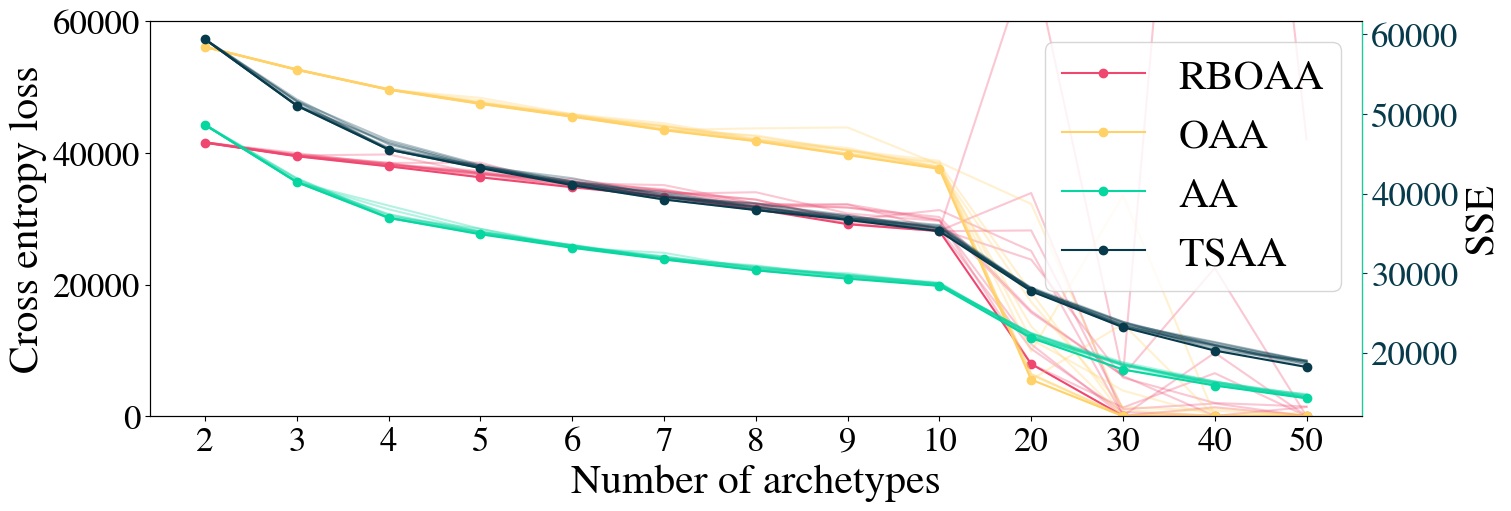

In [8]:
K_list = [2,3,4,5,6,7,8,9,10,20,30,40,50]
#K_list = [2,3,4,5,6,7,8,9,10]
path1 = "C:/Users/aejew/Downloads/ESS8_GB_results/ESS8_GB_results/All_AA_results.json"
#path2 = "C:/Users/aejew/Downloads/ESS8_GB_results/ESS8_GB_result_OSM"
loss_archetype_plot(K_list,results_path = path1, results_path2 = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_OSM_results/ESS8_GB_OSM_All_AA_results.json")

plt.savefig("Plots_for_paper/Error_K_GB.png",dpi=1000)

In [9]:

def calcMI(z1,z2):
    eps = 10e-16
    P = z1@z2.T
    PXY = P/P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0),np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY>0)
    MI = np.sum(PXY*np.log(eps+PXY/(eps+PXPY)))
    return MI
    
def calcNMI(z1,z2):
    NMI=(2*calcMI(z1,z2))/(calcMI(z1,z1)+calcMI(z2,z2))
    #NMI = NMI.reshape((z1.shape[0], z1.shape[0]))
    
    return NMI


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file


import itertools
#TODO : Lots of room for improvement with dataloader
def plot_NMI_stability(folder_path, K_list, repetitions= 10,folder_path2 = ''):
    methods = ["CAA", "OAA", "RBOAA","TSAA"]


    test = itertools.combinations(range(repetitions), 2)
    t = list(test)
    calcIDX = np.array(t)

    NMI_RBOAA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_OAA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_AA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_TSAA_complex_large = np.zeros((len(K_list),len(calcIDX)))

    for method in methods:
        i = 0
        for K in K_list:

            for j in range(len(calcIDX)):


                if method == "TSAA":
                    
                    filename1 = folder_path+"TSAA_objects/CAA"+"_K="+str(K)+"_rep="+str(calcIDX[j,0]) #+".npy"
                    filename2 = folder_path+"TSAA_objects/CAA"+"_K="+str(K)+"_rep="+str(calcIDX[j,1]) #+".npy"
                    file1 = load_result_obj(filename1)
                    file2 = load_result_obj(filename2)
                    file1 = file1.A
                    file2 = file2.A

                else:
                
                    filename1 = folder_path+str(method)+"_K="+str(K)+"_rep="+str(calcIDX[j,0]) #+".npy"
                    filename2 = folder_path+str(method)+"_K="+str(K)+"_rep="+str(calcIDX[j,1]) #+".npy"
                    file1 = load_result_obj(filename1)
                    file2 = load_result_obj(filename2)
                    file1 = file1.A
                    file2 = file2.A






                if method == "RBOAA":
                    NMI_RBOAA_complex_large[i,j] = calcNMI(file1,file2)

                elif method == "OAA":
                    NMI_OAA_complex_large[i,j] = calcNMI(file1,file2)

                elif method == "CAA":
                    NMI_AA_complex_large[i,j] = calcNMI(file1,file2)

                elif method == "TSAA":
                    NMI_TSAA_complex_large[i,j] = calcNMI(file1,file2)
            
            i += 1

    df1 = pd.DataFrame(NMI_RBOAA_complex_large.T, columns = K_list)
    df2 = pd.DataFrame(NMI_OAA_complex_large.T, columns = K_list)
    df3 = pd.DataFrame(NMI_AA_complex_large.T, columns = K_list)
    df4 = pd.DataFrame(NMI_TSAA_complex_large.T, columns = K_list)

    df1['Method'] = 'RBOAA'
    df2['Method'] = 'OAA'
    df3['Method'] = 'AA'
    df4['Method'] = 'TSAA'


    df1 = df1.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')
    df2 = df2.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')
    df3 = df3.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')
    df4 = df4.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')


    df = pd.concat([df1,df2,df3,df4])
    df.Method = df.Method.replace({'OAA': 'OAA', 'RBOAA': 'RBOAA', 'AA': 'AA', 'CAA': 'AA','TSAA':'TSAA'})

        
    methods = df['Method'].unique()
    #methods_colors = dict(zip(methods.tolist(), ["#EF476F", "#FFD166", "#06D6A0", "#073B4C"]))
    methods_colors = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSAA" : "#073B4C"}
    fig, ax = plt.subplots(1,1,figsize = (15,5), layout='constrained')

    ax = sns.boxplot(x='Archetypes', y="NMI", hue="Method", showmeans=True, data=df,palette=methods_colors,meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "black"})
    ax.xaxis.grid(True, which='major')
    [ax.axvline(x+.5,color='k') for x in ax.get_xticks()]
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)    
    ax.set_xlabel('Number of archetypes', fontsize=30)
    ax.set_ylabel('NMI', fontsize=30)

    ax.set_ylim([0,1.05])
    plt.legend(fontsize=30,loc = 'upper right')



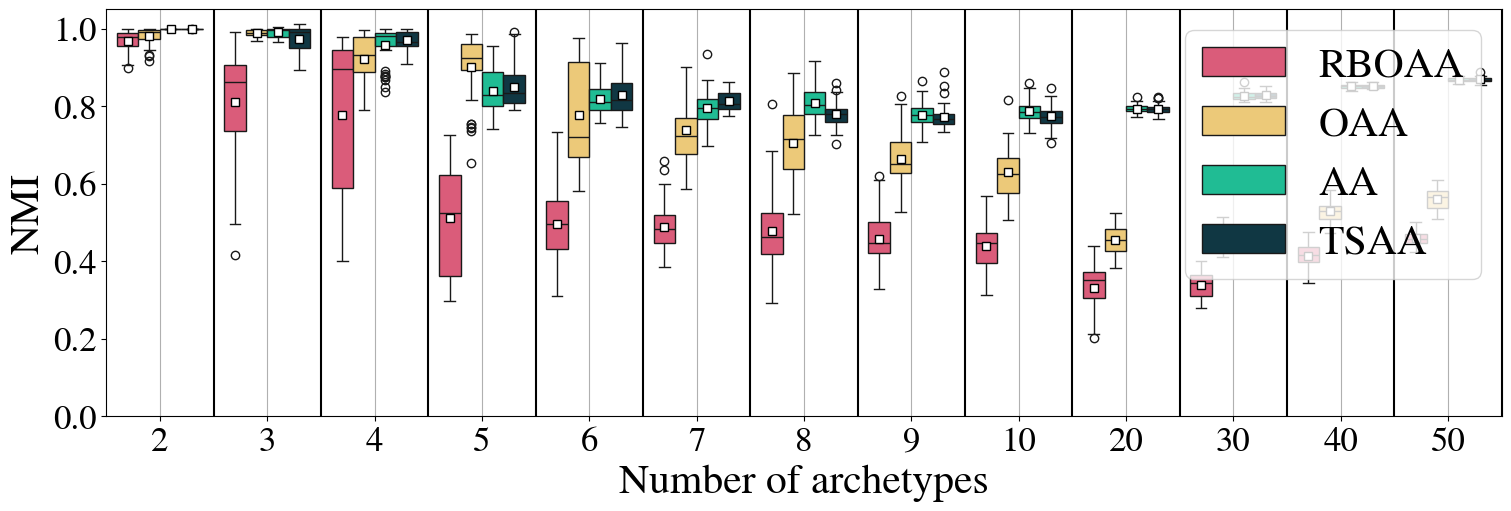

In [10]:
K_list = [2,3,4,5,6,7,8,9,10,20,30,40,50]


path = "C:/Users/aejew/Downloads/ESS8_GB_results/ESS8_GB_results/All_Res/"

plot_NMI_stability(path, K_list, repetitions= 10)


plt.savefig("Plots_for_paper/NMI_K_GB.png",dpi=1000)



In [11]:

import torch
def _calculate_probRBOAA(Xt,X_hat,b,sigma):
        z_next = (torch.gather(b,1,Xt)-X_hat)/sigma#[:,None]
        z_prev = (torch.gather(b,1,Xt-1)-X_hat)/sigma #[:,None]
        z_next[Xt == len(b[0,:])+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev
        

def _calculate_probOAA(Xt, X_hat, b, sigma):
        z_next = (b[Xt] - X_hat)/sigma
        z_prev = (b[Xt-1] - X_hat)/sigma
        z_next[Xt == len(b)+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev

        
def findProb(data,method, i, j, p):
    
    X_hat = torch.tensor(data[method][f'K{i}'][j].X_hat)
    Prob = torch.zeros(X_hat.shape)
    b = torch.tensor(data[method][f'K{i}'][j].b)
    sigma = torch.tensor(data[method][f'K{i}'][j].sigma)
    R_est = torch.zeros(X_hat.shape)

    #sigma = torch.tensor(naive_cor['OAA'][f'K{i}'][j].sigma)
    #sigmaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].sigma)

    #betaOAA = torch.tensor(naive_cor['OAA'][f'K{i}'][j].b)
    #betaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].b)

    #sigma_test = sigma.repeat(sigmaRBOAA.shape)
    #beta_test = betaOAA.repeat(betaRBOAA.shape)

    #X_hat = torch.tensor(naive_cor['OAA'][f'K{i}'][j].X_hat)


    for l in p:
        Xt = torch.ones(X_hat.shape,dtype = int)*(int(l))

        if method == 'OAA':
            Prob = _calculate_probOAA(Xt, X_hat, b, sigma)

        elif method == 'RBOAA':
            Prob =  _calculate_probRBOAA(Xt,X_hat,b,sigma.T)
                
        R_est += Prob*l


    return R_est






In [12]:
GB_res= load_analyses("ESS8_GB_results")
GB_res_corr = load_analyses("ESS8_GB_corrupted_results")
GB_res_OSM_corr = load_analyses("ESS8_GB_corrupted_OSM_results")

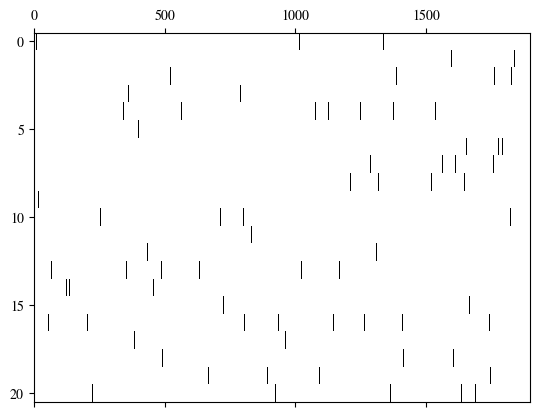

In [13]:
X = GB_res['RBOAA']['K1'][3].X
X_cor = GB_res_corr['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)

In [14]:
p = [1,2,3,4,5]
K_list = [2,3,4,5,6,7,8,9,10,20,30,40,50]

R_corr_CAA = np.zeros((len(K_list),10),dtype= object)
R_corr_RBOAA = np.zeros((len(K_list),10),dtype= object)
R_corr_OAA = np.zeros((len(K_list),10),dtype= object)
R_corr_TSOAA = np.zeros((len(K_list),10),dtype= object)

for i in range(len(K_list)): 
    for j in range(10):

        k = K_list[i]

        R_estRBOAA = findProb(GB_res_corr,'RBOAA', k, j, p)
        R_estOAA = findProb(GB_res_corr,'OAA', k, j, p)


        R_corr_CAA[i,j] = GB_res_corr['CAA']['K1'][3].X@GB_res_corr['CAA'][f'K{k}'][j].B@GB_res_corr['CAA'][f'K{k}'][j].A
        R_corr_OAA[i,j] = R_estOAA.numpy() #naive_cor['OAA']['K1'][3].X@naive_cor['OAA'][f'K{i}'][j].B@naive_cor['OAA'][f'K{i}'][j].A
        R_corr_RBOAA[i,j] = R_estRBOAA.numpy() #naive_cor['RBOAA']['K1'][3].X@naive_cor['RBOAA'][f'K{i}'][j].B@naive_cor['RBOAA'][f'K{i}'][j].A
        R_corr_TSOAA[i,j] = GB_res_corr['CAA']['K1'][3].X@GB_res_OSM_corr['TSAA'][f'K{k}'][j].B@GB_res_OSM_corr['TSAA'][f'K{k}'][j].A

In [15]:
SSE_CAA = np.zeros((len(K_list),10))
SSE_RBOAA = np.zeros((len(K_list),10))
SSE_OAA = np.zeros((len(K_list),10))
SSE_TSOAA = np.zeros((len(K_list),10))

for i in range(len(K_list)):
    for j in range(10):
        SSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))


In [16]:
np.arange(len(K_list))
K_list

len(np.min(SSE_TSOAA,axis = 1))

13

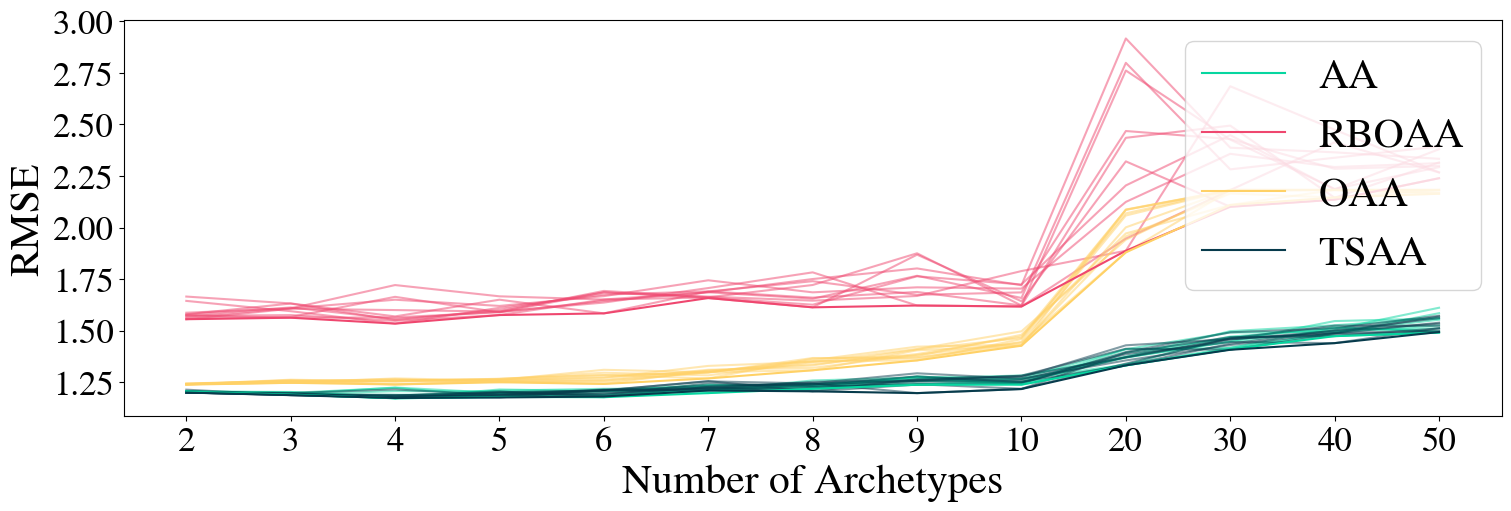

In [17]:




fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
ax.plot(range(len(K_list)), SSE_CAA, c = my_pallette['AA'],alpha = 0.5)
ax.plot(range(len(K_list)), SSE_RBOAA,c = my_pallette['RBOAA'],alpha= 0.5)
ax.plot(range(len(K_list)), SSE_OAA,c = my_pallette['OAA'],alpha= 0.5)
ax.plot(range(len(K_list)), SSE_TSOAA,c = my_pallette['TSOAA'],alpha = 0.5)

ax.plot(range(len(K_list)), np.min(SSE_CAA,axis = 1), c = my_pallette['AA'],label = 'AA')
ax.plot(range(len(K_list)), np.min(SSE_RBOAA,axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
ax.plot(range(len(K_list)), np.min(SSE_OAA,axis = 1),c =  my_pallette['OAA'],label = 'OAA')
ax.plot(range(len(K_list)), np.min(SSE_TSOAA,axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')


ax.set_xlabel("Number of Archetypes", fontsize = 30)
ax.set_ylabel("RMSE", fontsize = 30)



#plt.xticks(fontsize = 25)
ax.set_xticks(np.arange(len(K_list)))
ax.set_xticklabels(K_list,fontsize=25)
plt.yticks(fontsize = 25)
plt.legend(loc='upper right',fontsize = 30)

plt.savefig("Plots_for_paper/CorruptionError_GB.png",dpi=1000)



In [18]:
questions_long = ["Important to think new \n ideas and being creative","Important to be rich, have \n money and expensive things",
                    "Important that people are treated \n equally and have equal opportunities",
                    "Important to show \nabilities and be admired","Important to live in secure \nand safe surroundings",
                    "Important to try new \nand different things in life","Important to do what  \n is told and follow rules",
                    "Important to \nunderstand different people","Important to be humble and \nmodest, not draw attention",
                    "Important to \nhave a good time",
                    "Important to make \nown decisions and be free",
                    "Important to help people \nand care for others well-being",
                    "Important to be successful and \nthat people recognize achievements",
                    "Important that government is\n strong and ensures safety",
                    "Important to seek adventures \nand have an exciting life",
                    "Important to behave properly",
                    "Important to get \nrespect from others",
                    "Important to be loyal to friends \nand devote to people close",
                    "Important to care for \nnature and environment",
                    "Important to follow \ntraditions and customs",
                    "Important to seek fun and \nthings that give pleasure"]

questions_long = [x for _, x in sorted(zip(new_order, questions_long), key=lambda pair: pair[0])]

In [19]:
questions_trimmed = ["Think new ideas and being creative",
                    "Be rich, have money and expensive things",
                    "People are treated equally \nand have equal opportunities\n",
                    "Show abilities and be admired",
                    "Live in secure and safe surroundings",
                    "Try new and different things in life",
                    "Do what is told and follow rules",
                    "Understand different people",
                    "Be humble and modest, not draw attention",
                    "Have a good time",
                    "Make own decisions and be free",
                    "Help people and care for others well-being",
                    "Be successful and that \npeople recognize achievements\n",
                    "Government is strong and ensures safety",
                    "Seek adventures and have an exciting life",
                    "Behave properly",
                    "Get respect from others",
                    "Be loyal to friends \nand devote to people close\n",
                    "Care for nature and environment",
                    "Follow traditions and customs",
                    "Seek fun and things that give pleasure"]

questions_trimmed = [questions_trimmed[i] for i in new_order]

In [20]:
new_order

[0, 10, 5, 14, 9, 20, 3, 12, 1, 16, 8, 19, 6, 15, 4, 13, 11, 17, 2, 7, 18]

In [47]:
from colormap import rgb2hex, rgb2hls, hls2rgb
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist

def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.1):
    return adjust_color_lightness(r, g, b, 1 - factor)


def plot_archetypal_answers(X,archetypes,likert_text,questions,startColor, type = 'points'):

    def transform_data(data, p):
        likert_counts = pd.DataFrame(columns = range(1,p+1), index = np.arange(data.shape[0]))

        for i in range(data.shape[0]):
            likert_counts.iloc[i,(np.unique(data[i,:], return_counts=True)[0]-1)] = np.unique(data[i,:], return_counts=True)[1]

        likert_counts = likert_counts.fillna(0)

        return likert_counts
    
    likert_counts = transform_data(X, 6)

    fig, ax = plt.subplots(figsize=(5,8))
    

    ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8)

    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(likert_text, rotation = 45)

    ax.set_yticks(np.arange(0,likert_counts.shape[0]))
    ax.set_yticklabels(questions)

    colors = ['#8E7DBE','#8E7DBE','#8E7DBE','#8E7DBE','#8E7DBE','#8E7DBE',
                 '#2F3E46','#2F3E46','#2F3E46','#2F3E46',
                 '#4B7F52','#4B7F52','#4B7F52','#4B7F52','#4B7F52','#4B7F52',
                 '#FAAA8D','#FAAA8D','#FAAA8D','#FAAA8D','#FAAA8D']
    for xtick, color in zip(ax.get_yticklabels(), colors):
        xtick.set_color(color)

    my_text = "Important to/that:"
    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
    ax.text(-0.4, 1.02, my_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)


    
    #ax.axis["left"].major_ticklabels.set_ha("left") # Then it's simple to use set_ha.

    y = np.arange(likert_counts.shape[0])

    
    color = []
    color += [startColor]

    ## make off set such that middle archetype is centered
    center = (archetypes.shape[1])//2
    offset = (np.arange(archetypes.shape[1])-center)*0.2




    for i in range(archetypes.shape[1]):
        r, g, b  = hex_to_rgb(color[i])
        color += [darken_color(r, g, b,0.3)]


        if type == 'points':
            ax.scatter(archetypes[:,i]-1+offset[i], y, lw=5., color=color[i],label = f'Archetype {i+1}')
            #ax.scatter(archetypes[:,i]-1, y, lw=5., color=color[i],label = f'Archetype {i+1}')


        else:
            #line = plt.Line2D(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')
            #line.set_clip_on(False)
            #ax.add_line(line)
            ax.plot(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=2, fancybox=True, shadow=True)
    

    








C:\Users\aejew\AppData\Local\Temp\ipykernel_15796\2229374802.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


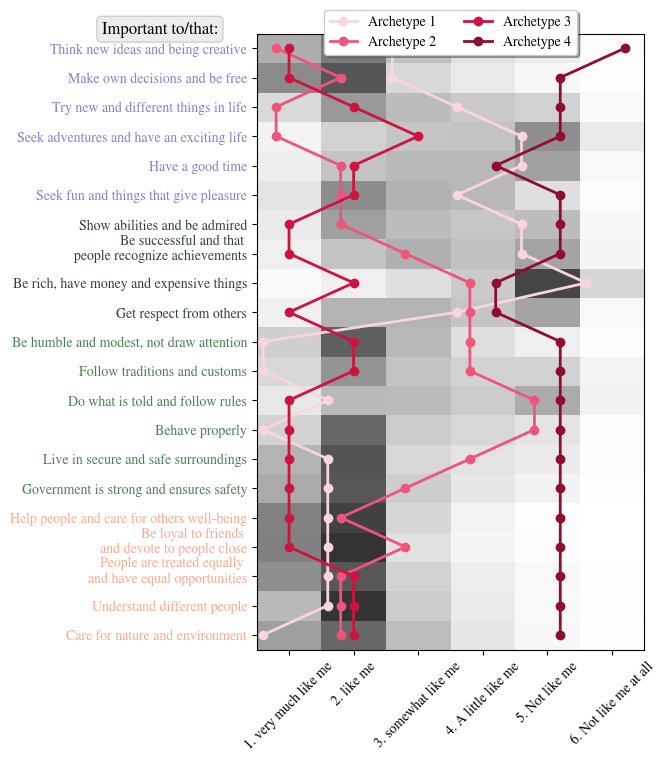

In [48]:

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/RBOAA_K=4_rep=2"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)
likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']

questions = [f'Question {i+1}' for i in range(file.X.shape[0])]

r,g,b = hex_to_rgb(my_pallette['RBOAA'])
new = adjust_color_lightness(r, g, b, 1+0.5)
plot_archetypal_answers(file.X[new_order,:],archetypes[new_order],likert_text,questions_trimmed,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_RBOAA_GB.png",dpi=1000)    

In [39]:
from colormap import rgb2hex, rgb2hls, hls2rgb
import matplotlib.pyplot as plt

def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.1):
    return adjust_color_lightness(r, g, b, 1 - factor)


def plot_archetypal_answers(X,archetypes,likert_text,questions,startColor, type = 'points'):

    def transform_data(data, p):
        likert_counts = pd.DataFrame(columns = range(1,p+1), index = np.arange(data.shape[0]))

        for i in range(data.shape[0]):
            likert_counts.iloc[i,(np.unique(data[i,:], return_counts=True)[0]-1)] = np.unique(data[i,:], return_counts=True)[1]

        likert_counts = likert_counts.fillna(0)

        return likert_counts
    
    likert_counts = transform_data(X, 6)

    fig, ax = plt.subplots(figsize=(5,8))

    ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8)
    #cbar = ax.figure.colorbar(ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8))

    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(likert_text, rotation = 45)

    ax.set_yticks(np.arange(0,likert_counts.shape[0]))
    ax.set_yticklabels(questions)

    y = np.arange(likert_counts.shape[0])

    
    color = []
    color += [startColor]

    ## make off set such that middle archetype is centered
    center = (archetypes.shape[1])//2
    offset = (np.arange(archetypes.shape[1])-center)*0.2




    for i in range(archetypes.shape[1]):
        r, g, b  = hex_to_rgb(color[i])
        color += [darken_color(r, g, b,0.3)]


        if type == 'points':
            ax.scatter(archetypes[:,i]-1+offset[i], y, lw=5., color=color[i],label = f'Archetype {i+1}')
            #ax.scatter(archetypes[:,i]-1, y, lw=5., color=color[i],label = f'Archetype {i+1}')


        else:
            #line = plt.Line2D(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')
            #line.set_clip_on(False)
            #ax.add_line(line)
            ax.plot(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=2, fancybox=True, shadow=True)
    

    





C:\Users\aejew\AppData\Local\Temp\ipykernel_15796\507710510.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


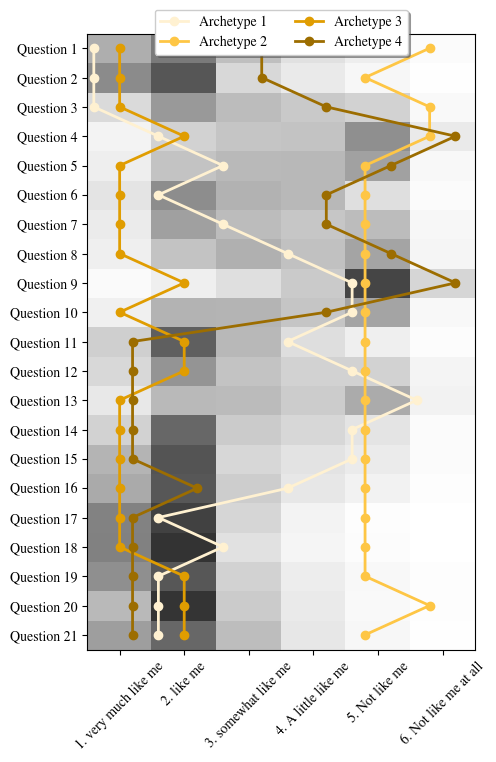

In [40]:


filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/OAA_K=4_rep=8"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)
likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']

questions = [f'Question {i+1}' for i in range(file.X.shape[0])]

r,g,b = hex_to_rgb(my_pallette['OAA'])
new = adjust_color_lightness(r, g, b, 1+0.3)
plot_archetypal_answers(file.X[new_order,:],archetypes[new_order],likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_OAA_GB.png",dpi=1000)

In [41]:
from colormap import rgb2hex, rgb2hls, hls2rgb
import matplotlib.pyplot as plt

def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.1):
    return adjust_color_lightness(r, g, b, 1 - factor)


def plot_archetypal_answers(X,archetypes,likert_text,questions,startColor, type = 'points'):

    def transform_data(data, p):
        likert_counts = pd.DataFrame(columns = range(1,p+1), index = np.arange(data.shape[0]))

        for i in range(data.shape[0]):
            likert_counts.iloc[i,(np.unique(data[i,:], return_counts=True)[0]-1)] = np.unique(data[i,:], return_counts=True)[1]

        likert_counts = likert_counts.fillna(0)

        return likert_counts
    
    likert_counts = transform_data(X, 6)

    fig, ax = plt.subplots(figsize=(5,8))

    ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8)
    #cbar = ax.figure.colorbar(ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8))

    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(likert_text, rotation = 45)

    #ax.set_yticks(np.arange(0,likert_counts.shape[0]))
    #ax.set_yticklabels(questions)

    ax.set_yticks([])
    

    y = np.arange(likert_counts.shape[0])

    
    color = []
    color += [startColor]

    ## make off set such that middle archetype is centered
    center = (archetypes.shape[1])//2
    offset = (np.arange(archetypes.shape[1])-center)*0.2




    for i in range(archetypes.shape[1]):
        r, g, b  = hex_to_rgb(color[i])
        color += [darken_color(r, g, b,0.3)]


        if type == 'points':
            ax.scatter(archetypes[:,i]-1+offset[i], y, lw=5., color=color[i],label = f'Archetype {i+1}')
            #ax.scatter(archetypes[:,i]-1, y, lw=5., color=color[i],label = f'Archetype {i+1}')


        else:
            #line = plt.Line2D(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')
            #line.set_clip_on(False)
            #ax.add_line(line)
            ax.plot(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=2, fancybox=True, shadow=True)
    

    





C:\Users\aejew\AppData\Local\Temp\ipykernel_15796\2955530264.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


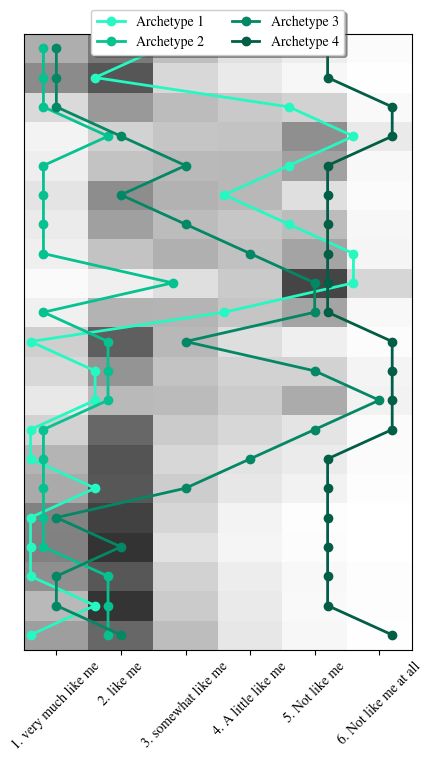

In [42]:

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/CAA_K=4_rep=4"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)

likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']
questions = [f'Question {i+1}' for i in range(file.X.shape[0])]

r,g,b = hex_to_rgb(my_pallette['AA'])
new = adjust_color_lightness(r, g, b, 1+0.3)
plot_archetypal_answers(file.X[new_order,:],archetypes[new_order],likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_AA_GB.png",dpi=1000)

In [27]:
filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/CAA_K=4_rep=4"
file2 = load_result_obj(filename)

C:\Users\aejew\AppData\Local\Temp\ipykernel_15796\2955530264.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


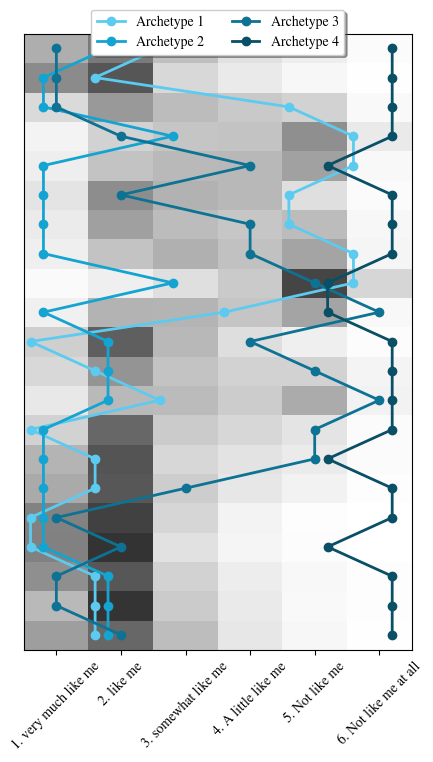

In [28]:

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_OSM_results/TSAA_objects/CAA_K=4_rep=4"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)

likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']
questions = [f'Question {i+1}' for i in range(file.X.shape[0])]

r,g,b = hex_to_rgb(my_pallette['TSOAA'])
new = adjust_color_lightness(r, g, b, 1+3)
plot_archetypal_answers(file2.X[new_order,:],archetypes[new_order],likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_TSAA_GB.png",dpi=1000)    

C:\Users\aejew\AppData\Local\Temp\ipykernel_15796\2955530264.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


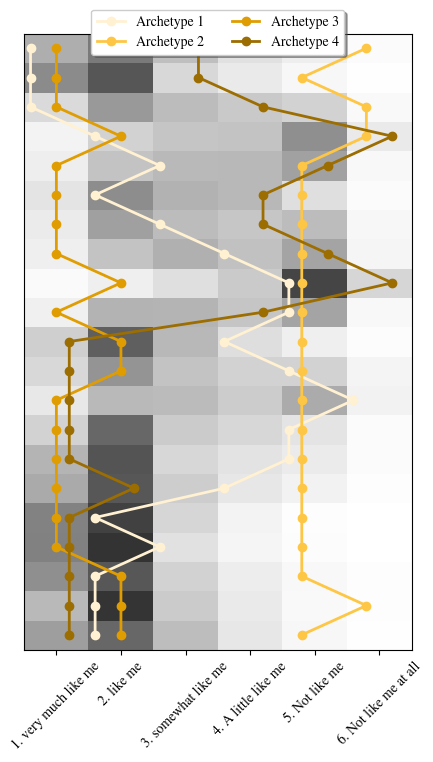

In [45]:
filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/OAA_K=4_rep=8"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)
likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']

questions = [f'Question {i+1}' for i in range(file.X.shape[0])]

r,g,b = hex_to_rgb(my_pallette['OAA'])
new = adjust_color_lightness(r, g, b, 1+0.3)
plot_archetypal_answers(file.X[new_order,:],archetypes[new_order],likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_OAA_GB.png",dpi=1000)

In [30]:
X = GB_res['OAA']['K4'][6].X

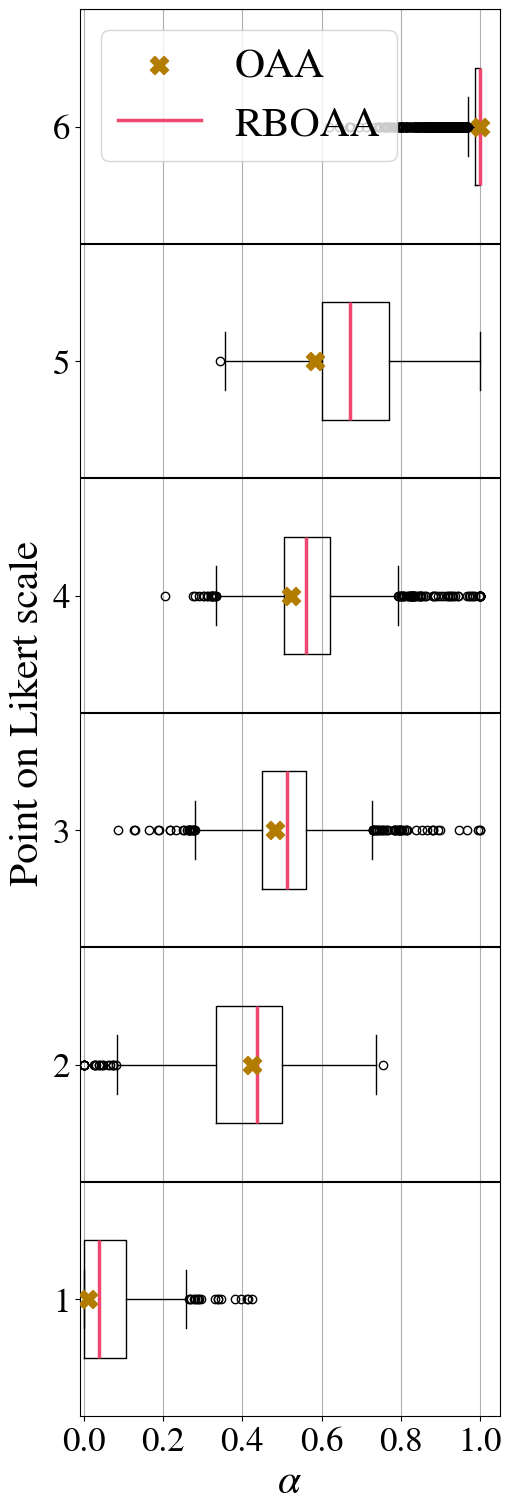

In [36]:
from src.visualizations.response_bias import response_bias_plot

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'




RBOAA_betas = GB_res['RBOAA']['K4'][2].b
OAA_betas = GB_res['OAA']['K4'][8].b

response_bias_plot(X, RBOAA_betas, OAA_betas,'RB_GB',synthetic_betas=None)

In [ ]:
HandlerBoxPlot()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

u_list = [2, 0, 0, 0, 1, 5, 0, 4, 0, 0]
n_list = [0, 0, 1, 0, 4, 3, 1, 1, 0, 6]
arr_ = list(np.arange(10, 11, 0.1))
x = list(np.arange(0, 10, 1))
y = [10.4, 10.5, 10.3, 10.7, 10.9, 10.5, 10.6, 10.3, 10.2, 10.4]

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].barh(arr_,u_list,height=0.1)
axs[0].invert_yaxis()

axs[1].plot(x, y)
axs[1].invert_yaxis()

axs[2].barh(arr_,n_list,height=0.1)
axs[2].invert_yaxis()


for i in range(1,len(axs)):
    axs[i].set_ylim( axs[0].get_ylim() ) # align axes
    axs[i].set_yticks([]) # set ticks to be empty (no ticks, no tick-labels)

fig.tight_layout()
plt.show()

In [ ]:
GB_res['RBOAA']['K3'][6].X.shape

(21, 1897)

In [ ]:
X_hat = GB_res['RBOAA']['K3'][6].X_hat

In [ ]:
alpha

[9.298324584960938e-05,
 0.4168597161769867,
 0.49245548248291016,
 0.5449632406234741,
 0.6233851909637451,
 1.0000202655792236]

In [ ]:
b_OAA = GB_res['OAA']['K4'][6].b

alpha_OAA = []
for j in range(len(b_OAA)-1):
    alpha_OAA += [(b_OAA[j+1]+b_OAA[j])/2]

In [ ]:
X_hat = GB_res['RBOAA']['K4'][6].X_hat
b = GB_res['RBOAA']['K4'][6].b
sigma = GB_res['RBOAA']['K4'][6].sigma
Xt = GB_res['RBOAA']['K4'][6].X.T


R = GB_res['RBOAA']['K4'][6].X@GB_res['RBOAA']['K4'][6].B@GB_res['RBOAA']['K4'][6].A

R

array([[4.54563547, 2.0709695 , 1.98636972, ..., 2.08130405, 2.04031279,
        3.57087044],
       [4.28921002, 3.9310285 , 4.41195169, ..., 3.49418748, 3.52614552,
        4.40589961],
       [3.8453253 , 2.05485607, 1.95356466, ..., 1.97970722, 1.93286668,
        3.12357003],
       ...,
       [3.96761536, 2.27288498, 2.20504588, ..., 2.08265422, 2.0292401 ,
        3.30265731],
       [4.21290975, 3.06553698, 3.34046071, ..., 2.24650611, 2.18668683,
        3.94569179],
       [4.32399873, 2.75466434, 2.72769782, ..., 2.79719264, 2.78036657,
        3.71753914]])

In [ ]:
b.shape

(1897, 7)

In [ ]:
Xt.shape

(1897, 21)

In [ ]:
R_est

tensor([[ 1.5473,  1.4667, 12.8453,  ...,  0.6057,  0.6033,  0.6645],
        [ 0.8177,  2.9967,  0.9899,  ...,  2.9859,  4.1976,  0.9842],
        [ 2.4220, 10.4412,  2.5549,  ...,  2.5400,  0.2674,  0.0555],
        ...,
        [ 8.0321,  1.1485, 10.2655,  ...,  1.1485,  1.0920,  8.8943],
        [ 0.1284,  0.1579,  0.1295,  ...,  0.1185,  0.1273,  0.1289],
        [ 2.2994,  1.0067,  2.4755,  ...,  2.4656,  1.3964,  4.2932]])

In [ ]:
X_hat

tensor([[0.7360, 0.2557, 0.2307,  ..., 0.2671, 0.2587, 0.5422],
        [0.6538, 0.6376, 0.7271,  ..., 0.5616, 0.5687, 0.6943],
        [0.6397, 0.2972, 0.2916,  ..., 0.2571, 0.2476, 0.5094],
        ...,
        [0.5715, 0.3368, 0.3005,  ..., 0.3340, 0.3245, 0.4654],
        [0.6096, 0.4519, 0.4936,  ..., 0.3090, 0.2979, 0.5759],
        [0.6330, 0.4045, 0.3953,  ..., 0.4152, 0.4123, 0.5420]])

In [ ]:
GB_res['RBOAA']['K3'][6]

In [ ]:
R_est

tensor([[6.8440e-04, 5.3639e-01, 1.4807e+00,  ..., 2.7629e-01, 2.9164e-01,
         1.2400e-02],
        [3.3065e-04, 1.4484e-02, 2.0287e-03,  ..., 5.4476e-02, 4.5632e-01,
         2.0723e-03],
        [2.3597e-02, 8.1500e-01, 8.3609e-01,  ..., 8.0374e-01, 1.2046e-01,
         2.5445e-03],
        ...,
        [2.3083e-03, 1.7829e-01, 5.5964e-01,  ..., 2.5271e-01, 3.3105e-01,
         2.5670e-02],
        [1.2180e-04, 5.8329e-03, 2.1623e-03,  ..., 2.6951e-02, 3.0155e-02,
         3.1872e-04],
        [5.4804e-04, 8.1052e-02, 1.0626e-01,  ..., 8.9052e-02, 1.5025e-01,
         1.4392e-01]])